## Debug

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from CoRT_builder import CoRT
import utils
import parametric_optim

import importlib

importlib.reload(utils)
importlib.reload(parametric_optim)

import warnings
from sklearn.exceptions import ConvergenceWarning
import copy

n_target = 50
n_source = 10
p = 50
K = 3
Ka = 1
h = 30
lamda = 0.05
s_vector = [0,0,0,0,0,0,0,0,0,0]
T = 5
s = len(s_vector)
CoRT_model = CoRT(alpha=lamda)
p_values = []

iteration = 10

for step in range(iteration):
    target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
    similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)
    X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

    model = Lasso(alpha=lamda, fit_intercept=False, tol=1e-10, max_iter=10000000)
    model.fit(X_combined, y_combined.ravel())
    beta_hat_target = model.coef_[-p:]

    active_indices = np.array([i for i, b in enumerate(beta_hat_target) if b != 0])

    if len(active_indices) == 0:
        print(f"Iteration {iter}: Lasso selected no features. Skipping.")
        continue

    j = np.random.choice(len(active_indices))

    X_target = target_data["X"]
    y_target = target_data["y"]
    X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)

    etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

    Sigma = np.eye(n_target)
    b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
    a_global = (Sigma - b_global @ etaj.T) @ y_target

    folds = utils.split_target(T, X_target, y_target, n_target)

    z_k = -20
    z_max = 20

    Z_train_list = parametric_optim.get_Z_train(z_k, folds, source_data, a_global, b_global, lamda, K, T)
    Z_val_list = parametric_optim.get_Z_val(z_k, folds, T, K, a_global, b_global, lamda, source_data)

    target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
    similar_source_current = parametric_optim.find_similar_source(z_k, a_global, b_global, lamda,  n_target, K, target_data_current, source_data, T=T, verbose=False)
    X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_current, source_data, target_data_current)
    L_CoRT, R_CoRT, Az = parametric_optim.get_Z_CoRT(X_combined_new, similar_source_current, lamda, a_global, b_global, source_data, z_k)

    offset = p * len(similar_source_index)
    Az_target_only = np.array([idx - offset for idx in Az if idx >= offset])

    z_list = [z_k]
    Az_list = []

    print("="*100)
    print("Initialization")
    print(f"Initial similar source index: {similar_source_index}")
    print(f"z_obs: {etajTy:.5f}")

    print(f"Initial Z_train_list: {Z_train_list}")
    print(f"Initial Z_val_list : {Z_val_list}")
    print(f"Initial Cort interval: {L_CoRT, R_CoRT}")
    print("="*100)

    step_count = 0
    stopper = "empty"
    matched_active_set = None

    while z_k < z_max:
        step_count += 1
        print(f"zk at step {step_count}: {z_k:.5f}")
        print(f"similar source current: {similar_source_current}")

        current_num_sources = len(similar_source_current)
        offset = p * current_num_sources
        Az_target_current = np.array([idx - offset for idx in Az if idx >= offset])
        Az_list.append(Az_target_current)

        # print(f"Current Az target: {Az_target_current}")

        old_Z_train_list = copy.deepcopy(Z_train_list)
        old_Z_val_list = copy.deepcopy(Z_val_list)
        old_L_CoRT, old_R_CoRT = L_CoRT, R_CoRT
        
        mn = z_max
        stopper = None

        for val in Z_train_list:
            if mn > val[4]:
                mn = val[4]
                stopper = f"TRAIN[type={val[0]}][t={val[1]}][k={val[2]}][L={val[3]:.5f}][R={val[4]:.5f}]"

        for val in Z_val_list:
            if mn > val[3]:
                mn = val[3]
                stopper = f"VAL[t={val[0]}][k={val[1]}][L={val[2]:.5f}][R={val[3]:.5f}]"

        if mn > R_CoRT:
            mn = R_CoRT
            stopper = f"CORT[{L_CoRT:.5f}, {R_CoRT:.5f}]"

        R_final = mn

        if R_final - z_k < -1e-9:
            print("[WARNING] R_final is before zk")
            z_k += 0.001

        z_k = max(R_final, z_k) + 1e-5

        if (z_k >= z_max):
            z_list.append(z_max)
        else:
            z_list.append(z_k)

        update_train_needed = False
        update_val_needed = False
        update_cort_needed = False
        
        if "TRAIN" in stopper:
            update_train_needed = True
            update_val_needed = True   
            update_cort_needed = True

        elif "VAL" in stopper:
            update_val_needed = True
            update_cort_needed = True

        elif "CORT" in stopper:
            update_cort_needed = True

        if update_train_needed:
            for val in Z_train_list:
                if val[4] <= z_k + 1e-9:
                    l, r = parametric_optim.update_Z_train(val, z_k, folds, source_data, a_global, b_global, lamda, K, T)
                    val[3] = l
                    val[4] = r

        if update_val_needed:
            for val in Z_val_list:
                l, r = parametric_optim.update_Z_val(val, z_k, folds, T, K, a_global, b_global, lamda, source_data)
                val[2] = l
                val[3] = r

        if update_cort_needed:
            target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
            similar_source_current = parametric_optim.find_similar_source(z_k, a_global, b_global, lamda, n_target, K, target_data_current, source_data, T=T, verbose=False)
            X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_current, source_data, target_data_current)
            L_CoRT, R_CoRT, Az = parametric_optim.get_Z_CoRT(X_combined_new, similar_source_current, lamda, a_global, b_global, source_data, z_k)

        print(f"==UPDATE==")
        for i, val in enumerate(Z_train_list):
            if val != old_Z_train_list[i]:
                print(f"OLD: {old_Z_train_list[i]}\nNEW: {val}")

        for i, val in enumerate(Z_val_list):
            if val != old_Z_val_list[i]:
                print(f"OLD: {old_Z_val_list[i]}\nNEW: {val}")

        if old_L_CoRT != L_CoRT or old_R_CoRT != R_CoRT:
            print(f"OLD: ({old_L_CoRT}, {old_R_CoRT})\nNEW: ({L_CoRT}, {R_CoRT})")

        print(f"Stopper: {stopper}")

        if np.array_equal(Az_target_current, active_indices):
            print(f"Detected current active target match with the observed at zk: {z_k}")

        print("\n")

    z_interval = []
    for i in range(len(Az_list)):
        if np.array_equal(active_indices, Az_list[i]):
                z_interval.append([z_list[i], z_list[i+1]]) 

    new_z_interval = []
    for interval in z_interval:
        if len(new_z_interval) == 0:
            new_z_interval.append(interval)
        else:
            dif = abs(interval[0] - new_z_interval[-1][1])
            if dif < 0.001:
                new_z_interval[-1][1] = interval[1]
            else:
                new_z_interval.append(interval)
    z_interval = new_z_interval
    
    print(f"z_obs: {etajTy:.5f}")
    print(f"{len(z_interval)} intervals found: {z_interval}")

    is_z_obs_in_intervals = False
    for i, interval in enumerate(z_interval):
        if interval[0] <= etajTy <= interval[1]:
            is_z_obs_in_intervals = True
            break

    if is_z_obs_in_intervals == False:
        print(f" WARNING: z_obs is not in the intervals:\nz_obs: {etajTy:.5f}\nIntervals:{z_interval}")
    else: 
        print("z_obs is in the intervals")

    p_value = parametric_optim.pivot(active_indices, Az_list, z_list, etaj, etajTy, 0, Sigma)
    p_values.append(p_value)

    if p_value == 0:
        print(" WARNING: p-value is 0")
    if p_value is None:
        print(" WARNING: p-value is None")

    print(f"Processing {step}, {p_value:.5f}")

# Plot results
plt.hist(p_values, density=True, bins=30, edgecolor='black')
plt.title("p-value Distribution")
plt.xlabel("p-value")
plt.ylabel('Density')
plt.tight_layout()
plt.show()

## Add paralled

Starting 200 iterations in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 194 out of 200 | elapsed:   37.8s remaining:    1.1s


Finished. Valid p-values collected: 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   38.8s finished


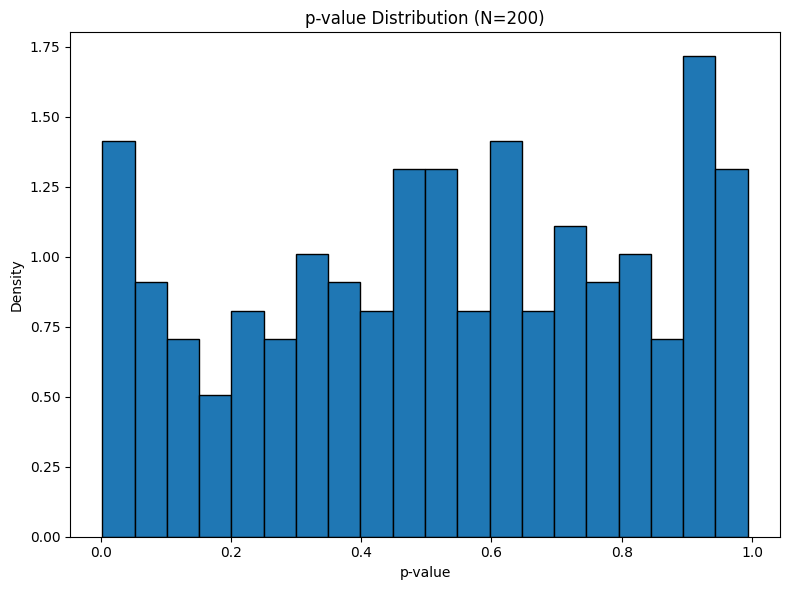

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from joblib import Parallel, delayed  # Import for parallelization
import warnings
from sklearn.exceptions import ConvergenceWarning
import copy

# Your modules
from CoRT_builder import CoRT
import utils
import parametric_optim

def run_single_trial(seed, n_target, n_source, p, K, Ka, h, lamda, s_vector, T):
    """
    Runs a single simulation iteration.
    """
    # Set unique seed for this parallel worker
    np.random.seed(seed)
    
    s = len(s_vector)
    CoRT_model = CoRT(alpha=lamda)
    
    # 1. Generate Data
    target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
    
    # 2. Initial Model Selection (Standard Lasso on CoRT matrix)
    similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)
    X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

    model = Lasso(alpha=lamda, fit_intercept=False, tol=1e-10, max_iter=10000000)
    model.fit(X_combined, y_combined.ravel())
    beta_hat_target = model.coef_[-p:]

    # [FIX] Sort indices to ensure consistent comparison later
    active_indices = np.sort(np.array([i for i, b in enumerate(beta_hat_target) if b != 0]))

    if len(active_indices) == 0:
        return None # Skip empty selection

    # 3. Construct Test Statistic
    j = np.random.choice(len(active_indices))
    
    X_target = target_data["X"]
    y_target = target_data["y"]
    X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)

    etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

    Sigma = np.eye(n_target)
    b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
    a_global = (Sigma - b_global @ etaj.T) @ y_target

    # 4. Path Following Initialization
    folds = utils.split_target(T, X_target, y_target, n_target)
    
    # [OPTIMIZATION] Search window restricted to relevant probability mass
    # Instead of [-20, 20], we look around z_obs. 
    # Standard Normal has 99.9999% mass in +/- 5.
    z_k = -20
    z_max = 20

    Z_train_list = parametric_optim.get_Z_train(z_k, folds, source_data, a_global, b_global, lamda, K, T)
    Z_val_list = parametric_optim.get_Z_val(z_k, folds, T, K, a_global, b_global, lamda, source_data)

    target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
    similar_source_current = parametric_optim.find_similar_source(z_k, a_global, b_global, lamda,  n_target, K, target_data_current, source_data, T=T, verbose=False)
    X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_current, source_data, target_data_current)
    L_CoRT, R_CoRT, Az = parametric_optim.get_Z_CoRT(X_combined_new, similar_source_current, lamda, a_global, b_global, source_data, z_k)

    offset = p * len(similar_source_index)
    
    z_list = [z_k]
    Az_list = []

    # 5. Path Following Loop
    step_count = 0
    
    while z_k < z_max:
        step_count += 1
        
        current_num_sources = len(similar_source_current)
        offset = p * current_num_sources
        
        # [FIX] Sort the active set found along the path
        Az_target_current = np.sort(np.array([idx - offset for idx in Az if idx >= offset]))
        Az_list.append(Az_target_current)

        mn = z_max
        stopper = None

        # Check Train Boundaries
        for val in Z_train_list:
            if mn > val[4]:
                mn = val[4]
                stopper = "TRAIN"

        # Check Val Boundaries
        for val in Z_val_list:
            if mn > val[3]:
                mn = val[3]
                stopper = "VAL"

        # Check CoRT Boundaries
        if mn > R_CoRT:
            mn = R_CoRT
            stopper = "CORT"

        R_final = mn

        if R_final - z_k < -1e-9:
            z_k += 0.001
        
        z_k = max(R_final, z_k) + 1e-5

        if (z_k >= z_max):
            z_list.append(z_max)
        else:
            z_list.append(z_k)

        update_train_needed = False
        update_val_needed = False
        update_cort_needed = False
        
        # Logic for lazy updates could go here, but kept simple for safety
        if stopper == "TRAIN":
            update_train_needed = True
            update_val_needed = True
            update_cort_needed = True

        elif stopper == "VAL":
            update_val_needed = True
            update_cort_needed = True

        elif stopper == "CORT":
            update_cort_needed = True

        if update_train_needed:
            for val in Z_train_list:
                if val[4] <= z_k + 1e-9:
                    l, r = parametric_optim.update_Z_train(val, z_k, folds, source_data, a_global, b_global, lamda, K, T)
                    val[3] = l
                    val[4] = r

        if update_val_needed:
            for val in Z_val_list:
                l, r = parametric_optim.update_Z_val(val, z_k, folds, T, K, a_global, b_global, lamda, source_data)
                val[2] = l
                val[3] = r

        if update_cort_needed:
            target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
            similar_source_current = parametric_optim.find_similar_source(z_k, a_global, b_global, lamda, n_target, K, target_data_current, source_data, T=T, verbose=False)
            X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_current, source_data, target_data_current)
            L_CoRT, R_CoRT, Az = parametric_optim.get_Z_CoRT(X_combined_new, similar_source_current, lamda, a_global, b_global, source_data, z_k)

    # 6. Extract Intervals & Calculate P-value
    z_interval = []
    
    # [FIX] Ensure active_indices is sorted (already done above)
    for i in range(len(Az_list)):
        # [FIX] Compare sorted arrays
        if np.array_equal(active_indices, np.sort(Az_list[i])):
             z_interval.append([z_list[i], z_list[i+1]]) 

    # Merge intervals
    new_z_interval = []
    for interval in z_interval:
        if len(new_z_interval) == 0:
            new_z_interval.append(interval)
        else:
            dif = abs(interval[0] - new_z_interval[-1][1])
            if dif < 0.001:
                new_z_interval[-1][1] = interval[1]
            else:
                new_z_interval.append(interval)
    z_interval = new_z_interval
    
    p_value = parametric_optim.pivot(active_indices, Az_list, z_list, etaj, etajTy, 0, Sigma)
    
    return p_value

# ==========================================
# Main Execution Block
# ==========================================
n_target = 30
n_source = 10
p = 10
K = 3
Ka = 1
h = 30
lamda = 0.05
s_vector = [0] * 1 
T = 3

iteration = 200

print(f"Starting {iteration} iterations in parallel...")

# Run in parallel using all available cores (n_jobs=-1)
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_single_trial)(i, n_target, n_source, p, K, Ka, h, lamda, s_vector, T) 
    for i in range(iteration)
)

# Filter out None results (skipped iterations)
p_values = [res for res in results if res is not None]

print(f"Finished. Valid p-values collected: {len(p_values)}")

# Plot results
if len(p_values) > 0:
    plt.figure(figsize=(8, 6))
    plt.hist(p_values, density=True, bins=10, edgecolor='black')
    plt.title(f"p-value Distribution (N={len(p_values)})")
    plt.xlabel("p-value")
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()
else:
    print("No valid p-values generated.")

## Test Parallel FPR, TPR

In [4]:
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from joblib import Parallel, delayed 
import oc
import warnings
import copy


from CoRT_builder import CoRT
import utils
import parametric_optim

def run_single_trial(seed, n_target, n_source, p, K, Ka, h, lamda, s_vector, T):
    """
    Runs a single simulation iteration.
    """
    # Set unique seed for this parallel worker
    np.random.seed(seed)
    
    s = len(s_vector)
    CoRT_model = CoRT(alpha=lamda)
    
    target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
    similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)
    X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

    model = Lasso(alpha=lamda, fit_intercept=False, tol=1e-10, max_iter=10000000)
    model.fit(X_combined, y_combined.ravel())
    beta_hat_target = model.coef_[-p:]

    active_indices = np.sort(np.array([i for i, b in enumerate(beta_hat_target) if b != 0]))

    if len(active_indices) == 0:
        return None 

    j = np.random.choice(len(active_indices))
    selected_feature_index = active_indices[j]
    
    X_target = target_data["X"]
    y_target = target_data["y"]
    X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)

    etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

    Sigma = np.eye(n_target)
    b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
    a_global = (Sigma - b_global @ etaj.T) @ y_target


    folds = utils.split_target(T, X_target, y_target, n_target)

    # Parametric
    z_k = -20
    z_max = 20

    Z_train_list = parametric_optim.get_Z_train(z_k, folds, source_data, a_global, b_global, lamda, K, T)
    Z_val_list = parametric_optim.get_Z_val(z_k, folds, T, K, a_global, b_global, lamda, source_data)

    target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
    similar_source_current = parametric_optim.find_similar_source(z_k, a_global, b_global, lamda,  n_target, K, target_data_current, source_data, T=T, verbose=False)
    X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_current, source_data, target_data_current)
    L_CoRT, R_CoRT, Az = parametric_optim.get_Z_CoRT(X_combined_new, similar_source_current, lamda, a_global, b_global, source_data, z_k)

    offset = p * len(similar_source_index)
    
    z_list = [z_k]
    Az_list = []

    # 5. Path Following Loop
    step_count = 0
    matched_active_set = None
    
    while z_k < z_max:
        step_count += 1
        
        current_num_sources = len(similar_source_current)
        offset = p * current_num_sources

        Az_target_current = np.array([idx - offset for idx in Az if idx >= offset])
        Az_list.append(Az_target_current)

        mn = z_max
        stopper = None

        for val in Z_train_list:
            if mn > val[4]:
                mn = val[4]
                stopper = "TRAIN"

        for val in Z_val_list:
            if mn > val[3]:
                mn = val[3]
                stopper = "VAL"

        if mn > R_CoRT:
            mn = R_CoRT
            stopper = "CORT"

        R_final = mn

        if R_final - z_k < -1e-9:
            z_k += 1e-5
        else:
            z_k = max(R_final, z_k) + 1e-5

        if (z_k >= z_max):
            z_list.append(z_max)
        else:
            z_list.append(z_k)

        update_train_needed = False
        update_val_needed = False
        update_cort_needed = False
        
        if stopper == "TRAIN":
            update_train_needed = True
            update_val_needed = True
            update_cort_needed = True

        elif stopper == "VAL":
            update_val_needed = True
            update_cort_needed = True

        elif stopper == "CORT":
            update_cort_needed = True

        if update_train_needed:
            for val in Z_train_list:
                if val[4] <= z_k + 1e-9:
                    l, r = parametric_optim.update_Z_train(val, z_k, folds, source_data, a_global, b_global, lamda, K, T)
                    val[3] = l
                    val[4] = r

        if update_val_needed:
            for val in Z_val_list:
                l, r = parametric_optim.update_Z_val(val, z_k, folds, T, K, a_global, b_global, lamda, source_data)
                val[2] = l
                val[3] = r

        if update_cort_needed:
            target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
            similar_source_current = parametric_optim.find_similar_source(z_k, a_global, b_global, lamda, n_target, K, target_data_current, source_data, T=T, verbose=False)
            X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_current, source_data, target_data_current)
            L_CoRT, R_CoRT, Az = parametric_optim.get_Z_CoRT(X_combined_new, similar_source_current, lamda, a_global, b_global, source_data, z_k)
    
    para_p_value = parametric_optim.pivot(active_indices, Az_list, z_list, etaj, etajTy, 0, Sigma)
    is_signal = (selected_feature_index < s) 
    para_result_dict = {
        "p_value": para_p_value,
        "is_signal": is_signal,
        "feature_idx": selected_feature_index
    }
    
    return para_result_dict

# ==========================================
# Main Execution Block
# ==========================================
n_target = 30
n_source = 10
p = 5
K = 3
Ka = 1
h = 30
lamda = 0.1
alpha = 0.05
s_vector = [1] * 1
T = 3
iteration = 500

print(f"Starting {iteration} iterations in parallel...")

# Run in parallel using all available cores (n_jobs=-1)
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_single_trial)(i, n_target, n_source, p, K, Ka, h, lamda, s_vector, T) 
    for i in range(iteration)
)

print("\n\n")

para_results_storage = [res for res in results if res is not None]
print("-" * 50 + "PARAMETRIC" + "-" * 50)
para_is_signal_cases = [r for r in para_results_storage if r['is_signal']]
para_not_signal_cases = [r for r in para_results_storage if not r['is_signal']]

para_false_positives = sum(1 for c in para_not_signal_cases if c['p_value'] <= alpha)
para_fpr = para_false_positives / len(para_not_signal_cases)
print(f"Parametric FPR: {para_fpr:.4f} (Target: {alpha})")

para_true_positives = sum(1 for r in para_is_signal_cases if r['p_value'] <= alpha)
para_tpr = para_true_positives / len(para_is_signal_cases)
print(f"Parametric TPR: {para_tpr:.4f}")

Starting 500 iterations in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:  




--------------------------------------------------PARAMETRIC--------------------------------------------------
Parametric FPR: 0.0515 (Target: 0.05)
Parametric TPR: 0.8947


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   37.9s finished
